### Basic properties of hybrid PV/STPV
One basic questions is "can we increase the photon flux into the active layer in the energy range that can split excitons?", where for 2D perovskite solar cells, we will consider this energy range to be between 0.35 and 0.38 $eV$ (3.2 - 3.5 $\mu m$).

To make this estimation, we will first compute the photon flux from the AM1.5 spectrum in this range; this is the number we have to exceed for such a device to be useful.

Second, we will compute the steady state temperature of an IR absorber/emitter that can be placed in between the sun and the active PV layer; in this case we will use polystyrene.
We will define the steady temperature as the temperature that balances the absorbed solar power with the emitted thermal radiation power:
\begin{equation}
\sigma_{abs,sol} = -\sigma_{emit}.
\end{equation}
We will define $\sigma_{abs,sol}$ as
\begin{equation}
\sigma_{abs,sol} = \int_0^{\infty} AM_{1.5}(\lambda) \epsilon_{PS}(\lambda) d\lambda
\end{equation}
where $AM_{1.5}(\lambda)$ is the AM1.5 solar spectrum and $\epsilon_{PS}(\lambda)$ 
is the absorptivity/emissivity of polystyrene; this term is independant of temperature.
The $\sigma_{emit}$ term will be defined as
\begin{equation}
\sigma_{emit} = 2\pi \int_0^{\infty} B(\lambda, T) \epsilon_{PS}(\lambda) d\lambda,
\end{equation}
where this emission takes on temperature dependence through Planck's blackbody law,
\begin{equation}
B(\lambda, T) = \frac{2hc^2}{\lambda^5} \frac{1}{{\rm exp}(\frac{hc}{\lambda k_B T}) - 1}.
\end{equation}
Note that the form of $\sigma_{emit}$ assumes the emissivity is independent of angle, leading to factor of $2\pi$ that accounts for the thermal radiation into the two hermispherical halfspaces that include the sky and the active layer, respectively.

With the steady state temperature of the polystyrene slab determined, we can compute the 
photon flux in the range 3.0 - 3.5 $\mu m$ and compare it to the solar flux.

  Gradient will be taken with respect to all layers! 
3.245616583416508e+19  photons / s / m^2 from sun that can split excitons
142.3655651428669  Watts per meter squared of sunlight absorbed by polystyrene
155
 Steady state temperature is  444.7236180904523 K or  171.7236180904523  C


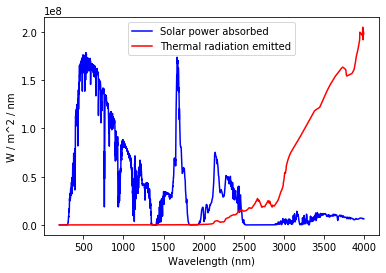

3.245616583416508e+19  photons / s / m^2 from sun that can split excitons
2.8325449034008566e+20  photons / s / m^2 from polystyrene that can split excitons
8.727293660852478 fold increase in photon flux using polystyrene


In [10]:
from wptherml.wpml import multilayer
from matplotlib import pyplot as plt
from wptherml.datalib import datalib
from wptherml.numlib import numlib
import numpy as np
h = 6.626e-34
c = 299792458.
### dictionary that stores basic properties 
### of the multilayer structure you want to simulate
structure = {
        'Temperature': 300,
        'Material_List' : ['Air', 'Si', 'Air'], 
        'Thickness_List': [0, 1000e-9, 0],
        'Lambda_List': [200e-9, 4000e-9, 10000]
     
}

### Just create a multilayer instance so we can have access to some
### basic quantities, including an array of wavelengths
solar_skin = multilayer(structure)

### Get the solar spectrum
AM = datalib.AM(solar_skin.lambda_array)

### Get the solar flux spectrum (number of photons per second per wavelength per meter squared)
AMflux = AM * solar_skin.lambda_array / (h * c)

### Integrate the solar flux between 3.2 and 3.5 microns to get the number of photons
### in that spectral range
AM_IR_tot = numlib.Integrate(AMflux, solar_skin.lambda_array, 3200e-9, 3500e-9)
print(AM_IR_tot," photons / s / m^2 from sun that can split excitons")

### Get transmission spectrum of thick (~1 mm) polystyrene slab, T
poly = datalib.poly_styrene_T(solar_skin.lambda_array)
### Get absorbed AM1.5 spectrum into this layer as AM1.5 * (1-T)... this assumes negligible 
### reflectivity
AM_absorb = AM * (1-poly)
sigma_sun = numlib.Integrate(AM_absorb, solar_skin.lambda_array, 200e-9, 4000e-9)
print(sigma_sun," Watts per meter squared of sunlight absorbed by polystyrene")



### Now we need to figure out at what temperature the thermal emission of polystyrene
### exactly balances the power absorbed by the sun; this will approximate the 
### steady-state temperature (neglecting convective & conductive heating/cooling forces)
### create an array of temperatures between 250 and 500 K
T = np.linspace(250,500,200)
### Empty arrays of thermal emitted power and difference between this and absorbed power
P_emit = []
diff = []
for temp in T:
    ### Get blackbody spectrum at current temperature
    rho = datalib.BB(solar_skin.lambda_array, temp)
    ### total thermal radiation from both sides of polystyrene given
    ### by integral of BB spectrum * (1-T); factor of 2 pi comes from angular 
    ### contribution
    sigma_emit = 2 * np.pi * numlib.Integrate(rho*(1-poly), solar_skin.lambda_array, 200e-9, 4000e-9)
    P_emit.append(sigma_emit)
    diff.append(np.abs(sigma_sun - sigma_emit))
    

### Let's get the location of the smallest element of diff, which should also index 
### of the steady state temperature from the T array
T_idx = np.argmin(diff)
print(T_idx)
print(" Steady state temperature is ",T[T_idx],"K or ",T[T_idx]-273," C")

### store steady state T
T_ss = T[T_idx]
### get polystyrene thermal emission
ps_te = datalib.BB(solar_skin.lambda_array, T_ss) * (1 - poly)
### plot against absorbed solar spectrum
plt.plot(1e9*solar_skin.lambda_array, AM_absorb, 'blue', label='Solar power absorbed')
plt.plot(1e9*solar_skin.lambda_array, 2*np.pi*ps_te, 'red', label='Thermal radiation emitted')
plt.xlabel("Wavelength (nm)")
plt.ylabel("W / m^2 / nm")
plt.legend()
plt.show()

### Now let's compute how many photons between 3.2 and 3.5 microns are 
### emitted from the polystyrene at T_ss towards the active layer (only into 1 halfspace,
### so angular contribution is only a factor of pi, not 2 pi as before!
ps_flux = ps_te * np.pi * solar_skin.lambda_array / (h * c)
### now get the total number of photons
ps_IR_tot = numlib.Integrate(ps_flux, solar_skin.lambda_array, 3200e-9, 3500e-9)
print(AM_IR_tot," photons / s / m^2 from sun that can split excitons")
print(ps_IR_tot," photons / s / m^2 from polystyrene that can split excitons")
print(ps_IR_tot/AM_IR_tot, "fold increase in photon flux using polystyrene")
